## Data Preprocessing and Importing

Import and standardize data

In [ ]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_img, train_lbl), (tst_img, tst_lbl) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


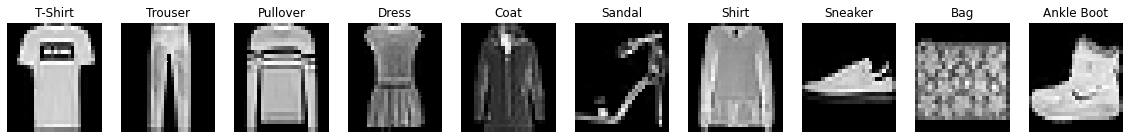

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
nclasses = len(classes)
figure = plt.figure(figsize=(nclasses*2,(2)));

for idx_cls, cls in enumerate(classes):
  # Find instance of current class
  idx = list(train_lbl.flatten()).index(idx_cls)

  # Plot example of each class
  plt_idx = idx_cls + 1
  p = plt.subplot(1, nclasses, plt_idx);
  p = sns.heatmap(np.reshape(train_img[idx], (28,28)), cmap=plt.cm.gray, 
            xticklabels=False, yticklabels=False, cbar=False);
  p = plt.axis('off');
  p = plt.title(cls);

In [ ]:
train_img = train_img / 255
tst_img = tst_img / 255

flat_train_img = train_img.reshape(train_img.shape[0], -1)
flat_tst_img = tst_img.reshape(tst_img.shape[0], -1)

## Logistic Regression (LR) Model and Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

Create and tune LR model through gridsearch of hyperparameters: solvers, penalty, and c_values.

Penalty and C value is tightly linked with solver so we can optimize for that parameter first.

This section takes long to execute, the findings of the hyperparameter optimizations can be found in the "Training Logistic Regression Model with Tuned Parameters".

### Tuning Section - Start

In [ ]:
def showOptimizaitonResults(lr_results):
  print("Best: %f using %s" % (lr_result.best_score_, lr_result.best_params_))
  means = lr_result.cv_results_['mean_test_score']
  stds = lr_result.cv_results_['std_test_score']
  params = lr_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

#### Solver Optimization

In [ ]:
lr = LogisticRegression(multi_class="multinomial", random_state=0, max_iter=1000)

lr_grid_solver = dict(
    solver=['sag', 'saga'],
    penalty=["l2", "none"],
    C=[0.1,1,10,100]
)

lr_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_grid_solver, n_jobs=-1, cv=lr_cv, scoring='accuracy', error_score=0, verbose=3)
lr_result = lr_grid_search.fit(flat_train_img[0:12000], train_lbl[0:12000])

Fitting 25 folds for each of 16 candidates, totalling 400 fits


In [ ]:
showOptimizaitonResults(lr_result)

There doesn't seem to be much performance difference between the solvers. This can be due to the bias in selecting the data (first 6000 images).

We can assume "saga" to be the best solver as it also provides the most options for the penalty hyperparameter to test from. 

Results: 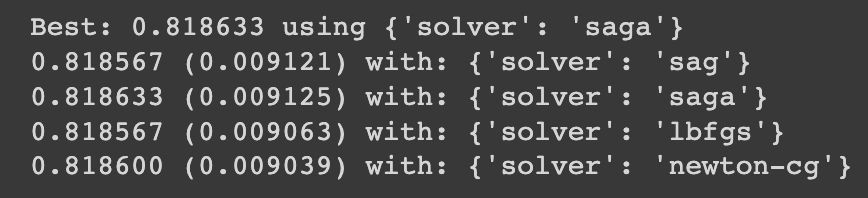

#### Penalty Optimization w. Elasticnet

In [ ]:
lr = LogisticRegression(multi_class="multinomial", solver="saga", penalty="elasticnet", random_state=0, C=0.01, max_iter=1000)

lr_grid_penalty = dict(
    l1_ratio=[0, 0.5, 1]
)

lr_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_grid_penalty, n_jobs=-1, cv=lr_cv, scoring='accuracy', error_score=0, verbose=3)
lr_result = lr_grid_search.fit(flat_train_img[0:6000], train_lbl[0:6000])

In [ ]:
showOptimizaitonResults(lr_result)

l2 regularization (l1_ratio=0) seems to be the best performing by a large margin. 

Results:
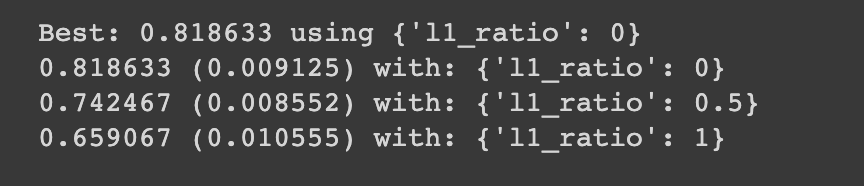

#### Optimizing Regularization Strength - C-Value

In [ ]:
lr = LogisticRegression(multi_class="multinomial", solver="saga", penalty="l2", random_state=0, max_iter=1000)

lr_grid_penalty = dict(
    C=[0.01, 0.1, 1, 10]
)

lr_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_grid_penalty, n_jobs=-1, cv=lr_cv, scoring='accuracy', error_score=0, verbose=3)
lr_result = lr_grid_search.fit(flat_train_img[0:6000], train_lbl[0:6000])

In [ ]:
showOptimizaitonResults(lr_result)

Between the given hyperparameter values for C, it does seem there is a local maximum around C=0.1 and scores drop off in lower and higher values.

Results: 
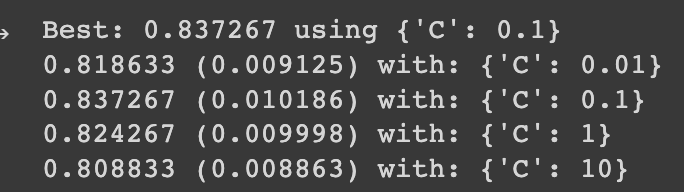

### Training Logistic Regression Model with Tuned Parameters
Solver - "saga"

Penalty - "l2"

C - 0.1

In [ ]:
lr = LogisticRegression(multi_class="multinomial", solver="saga", penalty="l2", C=0.1, random_state=0, n_jobs=-1, verbose=1, max_iter=1000)

## CNN Creation and Hyperparameter Tuning

Formulate vanilla CNN and modified CNN as specified in the paper, where modified CNN builds on vanilla CNN with added pooling, dropout layers and a LeakyReLU activation function

In [ ]:
def CreateVanillaModel():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28)))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu", input_shape=(28, 28)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation="relu"))
  model.add(tf.keras.layers.Dense(32, activation="relu"))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))
  return model

def CreateAdvModelLRelu(alpha_param):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=alpha_param), input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=alpha_param), input_shape=(28, 28)))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=alpha_param), input_shape=(28, 28)))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=alpha_param), input_shape=(28, 28)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=alpha_param), input_shape=(28, 28)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=alpha_param)))
  model.add(tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=alpha_param)))
  model.add(tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=alpha_param)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))
  return model

Define function to train any neural network, use categorical cross entropy as the loss and the adam optimizer which builds upon a stochastic gradient descent optimization algorithm.

In [ ]:
def train_model(m):
  m.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  history = m.fit(train_img, train_lbl, epochs=10, 
                      validation_data=(tst_img, tst_lbl))
  return history

Before comparing both models, tune the alpha hyperparameter of the LeakyReLu activation function in modified CNN. Tune it by training the modified CNN over the entire training set and then checking the accuracy scores over the validation set.

In [ ]:
alpha_levels = []
for i in range(100):
  if i % 20 == 0:
    alpha_levels.append(i/100)

training_hist = []

for alpha in alpha_levels:
  print("Fitting Advanced CNN with alpha of" + str(alpha))
  adv_m = CreateAdvModelLRelu(alpha)
  training_hist.append(train_model(adv_m))

Fitting Advanced CNN with alpha of0.0
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 164s 87ms/step - loss: 0.7313 - accuracy: 0.7404 - val_loss: 0.4787 - val_accuracy: 0.8389
Epoch 2/10
1875/1875 [==============================] - 150s 80ms/step - loss: 0.4372 - accuracy: 0.8493 - val_loss: 0.4422 - val_accuracy: 0.8529
Epoch 3/10
1875/1875 [==============================] - 148s 79ms/step - loss: 0.3701 - accuracy: 0.8713 - val_loss: 0.3628 - val_accuracy: 0.8683
Epoch 4/10
1875/1875 [==============================] - 144s 77ms/step - loss: 0.3377 - accuracy: 0.8829 - val_loss: 0.3335 - val_accuracy: 0.8820
Epoch 5/10
1875/1875 [==============================] - 146s 78ms/step - loss: 0.3088 - accuracy: 0.8915 - val_loss: 0.3436 - val_accuracy: 0.8858
Epoch 6/10
1875/1875 [==============================] - 147s 79ms/step - loss: 0.2944 - accuracy: 0.8974 - val_loss: 0.3197 - val_accuracy: 0.8880
Epoch 7/10
1875/1875 [==============================] - 152s 81ms/step - loss: 0.2770 - accuracy: 0.9034 - val_loss: 0.3208 - val

Formulate plot of tuned hyperparameter

In [ ]:
for idx, model in enumerate(training_hist):

  val_label = 'LeakyReLu Alpha of' + str(alpha_levels[idx])
  plt.plot(model.history['val_accuracy'], label=val_label)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Comparing Validation Accuracies at Varying LeakyReLu Alpha Parameters')

NameError: ignored

In [ ]:
vanilla_m = CreateVanillaModel()
vanilla_m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        73792     
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 64)                6


Found that LeakyReLu alpha parameter of 0.2 is ideal, hence pass that into modified CNN architecture

In [ ]:
adv_m_lr = CreateAdvModelLRelu(alpha_param=0.2)
adv_m_lr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          73792     
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 32)          18464     
                                                      

## Benchmarking all Model Performance

Fit each model (vanilla CNN, modified CNN, logistic regression)

In [ ]:
h_vanilla = train_model(vanilla_m)
h_adv_lr = train_model(adv_m_lr)
lr_model = lr.fit(flat_train_img, train_lbl)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1875/1875 [==============================] - 24s 7ms/step - loss: 0.4412 - accuracy: 0.8390 - val_loss: 0.3200 - val_accuracy: 0.8874
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2839 - accuracy: 0.8964 - val_loss: 0.2739 - val_accuracy: 0.9015
Epoch 3/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2358 - accuracy: 0.9129 - val_loss: 0.2783 - val_accuracy: 0.9002
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1990 - accuracy: 0.9278 - val_loss: 0.2584 - val_accuracy: 0.9086
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1644 - accuracy: 0.9396 - val_loss: 0.2595 - val_accuracy: 0.9113
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1353 - accuracy: 0.9496 - val_loss: 0.3048 - val_accuracy: 0.9035
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1091 - accuracy: 0.9599 - val_loss: 0.3365 - val_accuracy: 0.9

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 118 epochs took 276 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.6min finished


Compare model performance and plot it.

Text(0.5, 1.0, "Comparing Models' Training and Validation Accuracy")

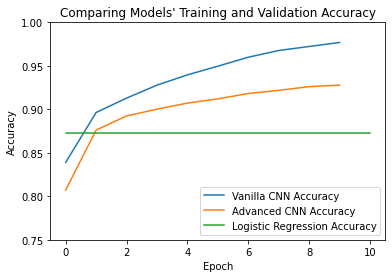

In [ ]:
import matplotlib.pyplot as plt

lr_train_perf = lr.score(flat_train_img, train_lbl)

plt.plot(h_vanilla.history['accuracy'], label='Vanilla CNN Accuracy')
plt.plot(h_adv_lr.history['accuracy'], label='Advanced CNN Accuracy')
plt.plot([0,2,4,6,8,10], [lr_train_perf]*6, label="Logistic Regression Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

plt.title("Comparing Models' Training and Validation Accuracy")

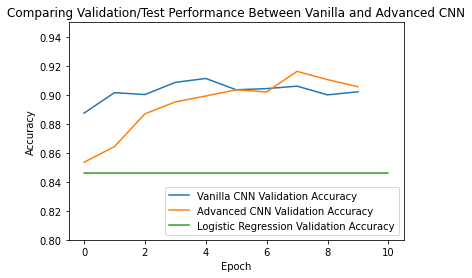

In [ ]:
lr_tst_perf = lr.score(flat_tst_img, tst_lbl)

plt.plot(h_vanilla.history['val_accuracy'], label = 'Vanilla CNN Validation Accuracy')
plt.plot(h_adv_lr.history['val_accuracy'], label = 'Advanced CNN Validation Accuracy')
plt.plot([0,2,4,6,8,10], [lr_tst_perf]*6, label="Logistic Regression Validation Accuracy")

plt.title("Comparing Model Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.95])
plt.legend(loc='lower right')

Formulate plot of model performance in final epoch of validation run versus model size to exemplify the accuracy-size trade-off that the paper highlights

Text(0, 0.5, 'Model Size (MB)')

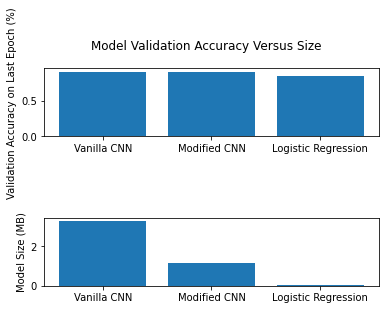

In [ ]:
# Size = # of coef * # of pixels * 4 (bytes per float32) / 10^6 (bytes in a MB)
lr_size = (len(lr.coef_) * len(lr.coef_[0]) * 4)/10**6

fig, axs = plt.subplots(2)
fig.suptitle('Model Validation Accuracy Versus Size')
fig.subplots_adjust(hspace=1.2)
axs[0].bar(['Vanilla CNN', 'Modified CNN', 'Logistic Regression'], [h_vanilla.history['val_accuracy'][9], h_adv_lr.history['val_accuracy'][9], lr_tst_perf])
axs[0].set_ylabel("Validation Accuracy on Last Epoch (%)")
axs[1].bar(['Vanilla CNN', 'Modified CNN', 'Logistic Regression'], [3.24,1.13, lr_size])
axs[1].set_ylabel("Model Size (MB)")


## Visualizing Results

Formulate confusion matrices for training results of every model

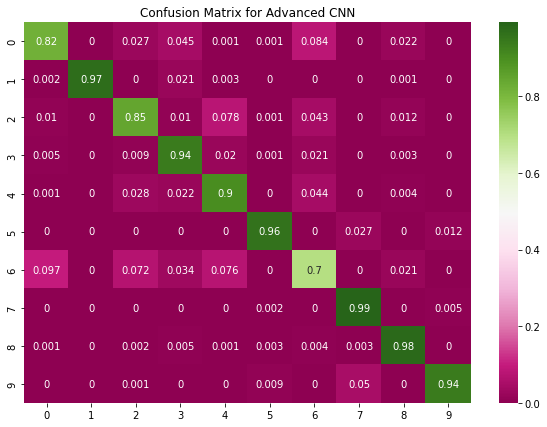

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

adv_cnn_predicted_labels = []
for classification in adv_m_lr.predict(tst_img):
  adv_cnn_predicted_labels.append(np.argmax(classification))


adv_cnn_conf_matrix = confusion_matrix(tst_lbl, adv_cnn_predicted_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize='true')

df_cm = pd.DataFrame(adv_cnn_conf_matrix, index = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
                  columns = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Advanced CNN")
sn.heatmap(df_cm, annot=True, cmap="PiYG")

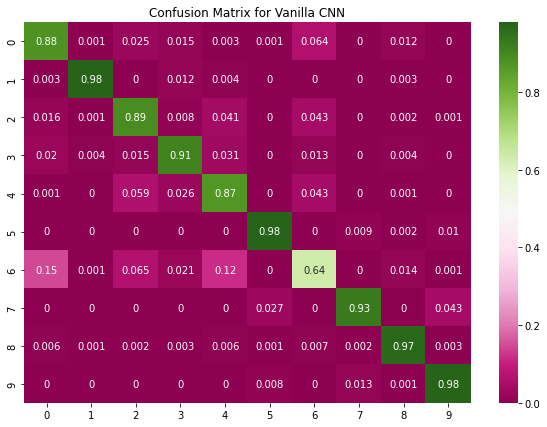

In [ ]:
vanilla_cnn_predicted_labels = []
for classification in vanilla_m.predict(tst_img):
  vanilla_cnn_predicted_labels.append(np.argmax(classification))


vanilla_cnn_conf_matrix = confusion_matrix(tst_lbl, vanilla_cnn_predicted_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize='true')

df_cm = pd.DataFrame(vanilla_cnn_conf_matrix, index = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
                  columns = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Vanilla CNN")
sn.heatmap(df_cm, annot=True, cmap="PiYG")

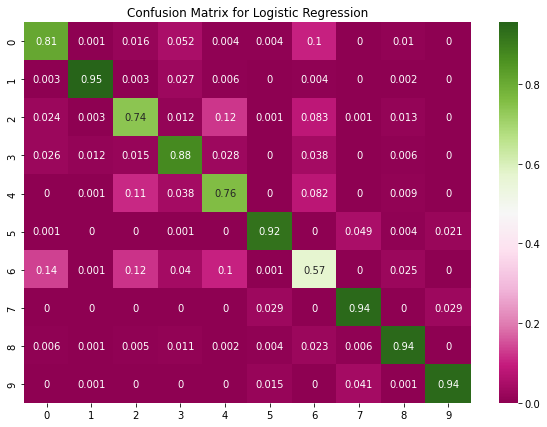

In [ ]:
lr_predicted_labels = []
for classification in lr.predict(flat_tst_img):
  lr_predicted_labels.append(classification)


lr_conf_matrix = confusion_matrix(tst_lbl, lr_predicted_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize='true')

df_cm = pd.DataFrame(lr_conf_matrix, index = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
                  columns = [i for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Logistic Regression")
sn.heatmap(df_cm, annot=True, cmap="PiYG")

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(tst_lbl, adv_cnn_predicted_labels, average='macro'))
print(f1_score(tst_lbl, vanilla_cnn_predicted_labels, average='macro'))
print(f1_score(tst_lbl, lr_predicted_labels, average='macro'))

0.9082299496682849
0.9040316219816376
0.8451791051659052


## Misc - Areas of Improvement - Class 6 Performance


All models seemed to struggle with class 6 predictions. It had the lowest true positive instances out of the dataset. 

It seems this is due to how similar other classes look like the shirt (6) class. For futuer work, differentiating this class more from the others could prove to add the greatest improvement to accuracy for all models.

(-0.5, 27.5, 27.5, -0.5)

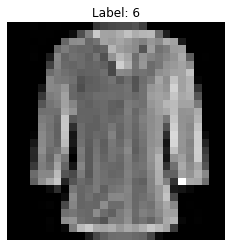

In [ ]:
sample_idx = list(tst_lbl.flatten()).index(6)

z = [ lr.intercept_[k] + np.dot(lr.coef_[k], flat_tst_img[sample_idx]) for k in range(10) ]
plt.imshow(flat_tst_img[sample_idx].reshape(28,28), cmap="gray");
plt.title('Label: ' + str(tst_lbl[sample_idx]))
plt.axis('off')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


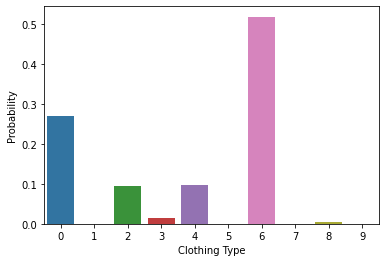

In [ ]:
#conditional probability
exps = [np.exp(z[k]) for k in range(10)]
exps_sum = np.sum(exps)
probs = exps/exps_sum
probs

#plot
sn.barplot(np.arange(0,10), probs);
plt.ylabel("Probability");
plt.xlabel("Clothing Type");